In [35]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

In [105]:
sx = sp.csr_matrix([[0,1],[1,0]], dtype=complex)
sy = sp.csr_matrix([[0,-1j],[1j,0]], dtype=complex)
sz = sp.csr_matrix([[1,0],[0,-1]], dtype=complex)
Iq = sp.eye(2, format='csr', dtype=complex)

def boson_ops(Nmax):
    dim = Nmax + 1
    # 'a' has sqrt(n) on the upper diagonal
    data = np.sqrt(np.arange(1, dim))
    a = sp.diags(data, 1, shape=(dim, dim), dtype=complex).tocsr()
    ad = a.conj().T
    nb = (ad @ a).tocsr()
    Ib = sp.eye(dim, format='csr', dtype=complex)
    return a, ad, nb, Ib

def cell_ops(Nmax):
    a, ad, nb, Ib = boson_ops(Nmax)
    A  = sp.kron(a , Iq, format='csr')
    Ad = sp.kron(ad, Iq, format='csr')
    Nb = sp.kron(nb, Iq, format='csr')
    Xb = A + Ad
    Yb = Ad - A
    Sx = sp.kron(Ib, sx, format='csr')
    Sy = sp.kron(Ib, sy, format='csr')
    Sz = sp.kron(Ib, sz, format='csr')
    Sp = 0.5 * (Sx + 1j * Sy)  
    I  = sp.kron(Ib, Iq, format='csr')
    return dict(A=A, Ad=Ad, Nb=Nb, Xb=Xb, Yb=Yb, Sx=Sx, Sy=Sy, Sz=Sz, Sp=Sp, I=I)

# ----- embedding helpers on the chain of L cells -----
def embed_one(op, site, L, d):
    I = sp.eye(d, format='csr', dtype=complex)
    mats = [I]*L
    mats[site] = op
    out = mats[0]
    for M in mats[1:]:
        out = sp.kron(out, M, format='csr')
    return out

def embed_two(opL, siteL, opR, siteR, L, d):
    assert siteL != siteR
    lo, hi = sorted((siteL, siteR))
    I = sp.eye(d, format='csr', dtype=complex)
    mats = [I]*L
    mats[siteL] = opL
    mats[siteR] = opR
    out = mats[0]
    for M in mats[1:]:
        out = sp.kron(out, M, format='csr')
    return out

# ----- full many-body Hamiltonian (open boundaries) -----
def build_H_full(L, omega_q, omega_c, g_phi, g_q, g_c, Nmax):
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    H = sp.csr_matrix((d**L, d**L), dtype=complex)

    # on-site terms
    for n in range(L):
        H += (omega_q/2) * embed_one(ops['Sz'], n, L, d)
        H +=  omega_c    * embed_one(ops['Nb'], n, L, d)
        H +=  g_phi      * embed_one(ops['Sx'] @ ops['Xb'], n, L, d)  # σ^x ⊗ (a†+a)

    # inter-cell terms
    g_qc = np.sqrt(g_q * g_c)
    for n in range(L-1):
        # -g_q σ^y_n σ^y_{n+1}
        H += -g_q * embed_two(ops['Sy'], n, ops['Sy'], n+1, L, d)
        # -g_c (Yb_n)(Yb_{n+1})  with Yb = (a† - a) ⊗ I
        H += -g_c * embed_two(ops['Yb'], n, ops['Yb'], n+1, L, d)
        # + i sqrt(g_q g_c) * ( - σ^y_n Yb_{n+1} + Yb_n σ^y_{n+1} )
        H += 1j * g_qc * (
             - embed_two(ops['Sy'], n, ops['Yb'], n+1, L, d)
             + embed_two(ops['Yb'], n, ops['Sy'], n+1, L, d)
        )
    return H

# ----- initial states -----
def local_state(Nmax, boson='vac', spin='down', alpha=0.0):
    # boson |n=0> or |1> etc., or coherent
    dim = Nmax + 1
    if boson == 'vac':
        b = np.zeros(dim); b[0] = 1.0
    elif isinstance(boson, int):
        b = np.zeros(dim); 
        if boson > Nmax: raise ValueError("boson Fock > Nmax")
        b[boson] = 1.0
    elif boson == 'coh':
        n = np.arange(dim)
        b = np.exp(-0.5*abs(alpha)**2) * (alpha**n) / np.sqrt(sp.special.factorial(n).A.ravel() if isinstance(sp.special.factorial(n), sp.csr_matrix) else np.array([np.math.factorial(k) for k in n]))
        b = b / np.linalg.norm(b)
    else:
        raise ValueError("boson must be 'vac', int, or 'coh'")
    s = np.array([1,0]) if spin == 'down' else np.array([0,1])
    return np.kron(b, s).astype(complex)

def product_state(L, Nmax, left_excitation=('boson',1)):
    vloc = [local_state(Nmax, boson='vac', spin='down')]
    vecs = []
    for i in range(L):
        if i == 0:
            if left_excitation[0] == 'boson':
                vecs.append(local_state(Nmax, boson=left_excitation[1], spin='down'))
            elif left_excitation[0] == 'spin':
                vecs.append(local_state(Nmax, boson='vac', spin='up'))
            else:
                vecs.append(local_state(Nmax, boson='vac', spin='down'))
        else:
            vecs.append(local_state(Nmax, boson='vac', spin='down'))
    psi = vecs[0]
    for v in vecs[1:]:
        psi = np.kron(psi, v)
    return psi

# ----- time evolution via Krylov action -----
def evolve(H, psi0, t_array):
    A = (-1j) * H  # generator for expm_multiply (exp(t*A))
    t0, t1 = float(t_array[0]), float(t_array[-1])
    Y = spla.expm_multiply(A, psi0, start=t0, stop=t1, num=len(t_array), endpoint=True)
    return np.asarray(Y)  # shape (T, D)

# ----- measurements -----
def measure_local_ops(L, Nmax, states):
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    # pre-embed once
    Nb_ops = [embed_one(ops['Nb'], i, L, d) for i in range(L)]
    Sz_ops = [embed_one(ops['Sz'], i, L, d) for i in range(L)]
    T = states.shape[0]
    nb = np.zeros((T, L), dtype=float)
    sz = np.zeros((T, L), dtype=float)
    for t in range(T):
        psi = states[t]
        for i in range(L):
            nb[t, i] = np.real(np.vdot(psi, Nb_ops[i] @ psi))
            sz[t, i] = np.real(np.vdot(psi, Sz_ops[i] @ psi))
    # edge probability proxy over first 2–3 cells
    P_edge = nb[:, :3].sum(axis=1) + 0.5 * (1 - sz[:, :3]).sum(axis=1)
    return nb, sz, P_edge


def vacuum_state(L, Nmax):
    dim_b = Nmax + 1
    b0 = np.zeros(dim_b); b0[0] = 1.0
    s_g = np.array([0.0, 1.0])   # <-- ground is σz=-1
    v_cell = np.kron(b0, s_g).astype(complex)
    psi = v_cell
    for _ in range(L-1):
        psi = np.kron(psi, v_cell)
    return psi

# --- build single-excitation edge state from profiles a_n, b_n ---
def make_edge_state(L, Nmax, a_profile, b_profile=None):
    """
    a_profile, b_profile: arrays of length L with complex amplitudes on each cell.
      a_profile[n] weights one-photon excitation on cell n, b_profile[n] weights qubit-up.
      If b_profile is None, use b_profile = a_profile.
    Returns normalized state vector psi0 (shape d^L).
    """
    a_profile = np.asarray(a_profile, dtype=complex)
    if b_profile is None:
        b_profile = a_profile.copy()
    else:
        b_profile = np.asarray(b_profile, dtype=complex)
    assert len(a_profile) == L and len(b_profile) == L

    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    vac = vacuum_state(L, Nmax)

    # pre-embed ladder operators once
    Ad_list = [embed_one(ops['Ad'], n, L, d) for n in range(L)]
    Sp_list = [embed_one(ops['Sp'], n, L, d) for n in range(L)]

    psi = np.zeros_like(vac)
    for n in range(L):
        if a_profile[n] != 0:
            psi += a_profile[n] * (Ad_list[n] @ vac)
        if b_profile[n] != 0:
            psi += b_profile[n] * (Sp_list[n] @ vac)

    # normalize (your profiles might already be normalized, but do it safely)
    norm = np.linalg.norm(psi)
    if norm == 0:
        raise ValueError("Profiles produced a zero vector; check Nmax>=1 and inputs.")
    return psi / norm

# --- your analytic left-edge profile from δ and g ---
def left_edge_state(delta, g, N):
    lam = delta / (4.0 * g)
    r = lam**2
    # avoid division by zero if r ~ 1; handle N finite
    if abs(1 - r) < 1e-14:
        N0 = np.sqrt(2 * N)  # limit r->1
    else:
        N0 = 2.0 * np.sqrt((1 - r**N) / (1 - r)) * (2**-0.5)
    a_R = (lam ** np.arange(N)) / N0
    return a_R

def single_excitation_basis(L, Nmax):
    """Return a matrix Phi with orthonormal columns spanning the 1-excitation sector."""
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    vac = vacuum_state(L, Nmax)

    # basis vectors: one photon on cell n, or one qubit excited on cell n
    vecs = []
    labels = []  # ('a', n) or ('b', n)
    for n in range(L):
        v = embed_one(ops['Ad'], n, L, d) @ vac
        if np.linalg.norm(v) > 0:
            vecs.append(v / np.linalg.norm(v)); labels.append(('a', n))
        v = embed_one(ops['Sp'], n, L, d) @ vac
        # Sp|g> is normalized; keep for symmetry
        vecs.append(v) ; labels.append(('b', n))
    # stack into D x (2L) matrix with orthonormal columns
    Phi = np.column_stack(vecs)  # already orthonormal here
    return Phi, labels

def project_to_single_excitation(states, L, Nmax, n_edge=3):
    """
    states: array (T, D) many-body state over time
    returns:
      p1(t): total weight in 1-excitation sector
      P_edge_1(t): edge weight *within* that sector (sum over first n_edge cells)
    """
    Phi, labels = single_excitation_basis(L, Nmax)  # D x K (K=2L)
    T = states.shape[0]
    c = (states @ Phi).astype(complex)              # shape (T, K), coefficients in 1-excitation basis
    p1 = np.sum(np.abs(c)**2, axis=1)               # weight in the sector
    # pick columns that live on first n_edge cells
    idx_edge = [k for k,(w,n) in enumerate(labels) if n < n_edge]
    P_edge_1 = np.sum(np.abs(c[:, idx_edge])**2, axis=1)
    return p1, P_edge_1


In [106]:
def eta_local(omega_q, omega_c, g_phi):
    # Bloch–Siegert–corrected detuning (rough, but effective)
    delta_bs = 2.0 * g_phi**2 / (omega_q + omega_c)
    Delta_eff = (omega_q - omega_c) + delta_bs
    # JC mixing angle for n=0 manifold
    theta = 0.5 * np.arctan2(2*g_phi, Delta_eff)
    return np.tan(theta)  # b/a


In [107]:
L = 5
Nmax = 1

omega_q = 1
omega_c = 3
g_phi   = 0
g_q     = 1
g_c     = 1
delta = omega_c-omega_q

# time grid (units of 1/ coupling)
t_max = 100
T = 1000
t = np.linspace(0.0, t_max, T)

H = build_H_full(L, omega_q, omega_c, g_phi, g_q, g_c, Nmax)

a_left = left_edge_state(delta, g_c, L)
# same profile on boson and qubit components:
psi0 = make_edge_state(L, Nmax, a_left, b_profile=a_left)

In [108]:
# build psi0 from your profile
a_left = left_edge_state(delta, g_c, L)   # your function
psi0 = make_edge_state(L, Nmax, a_left, b_profile=a_left)

# evolve
states = evolve(H, psi0, t)

# corrected raw observables
nb, sz, _ = measure_local_ops(L, Nmax, states)
p_qubit_exc = 0.5*(1.0 + sz)              # per site, per time
P_edge_raw = nb[:, :3].sum(1) + p_qubit_exc[:, :3].sum(1)

# projected (RWA-like) observables
p1, P_edge_1 = project_to_single_excitation(states, L, Nmax, n_edge=3)
P_edge_conditional = P_edge_1 / np.maximum(p1, 1e-15)


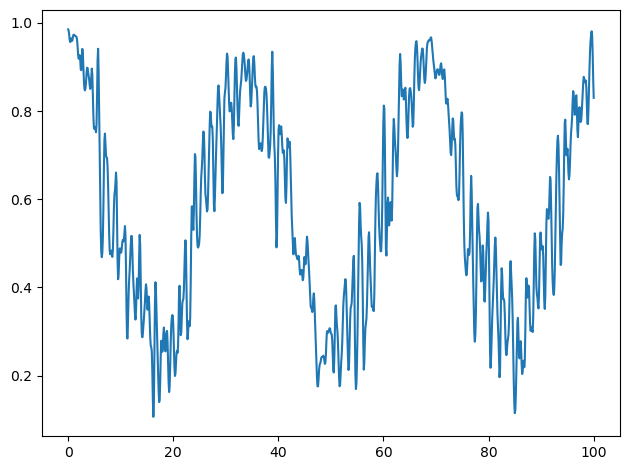

In [109]:
fig, ax = plt.subplots()

ax.plot(t, P_edge_conditional)
fig.tight_layout()

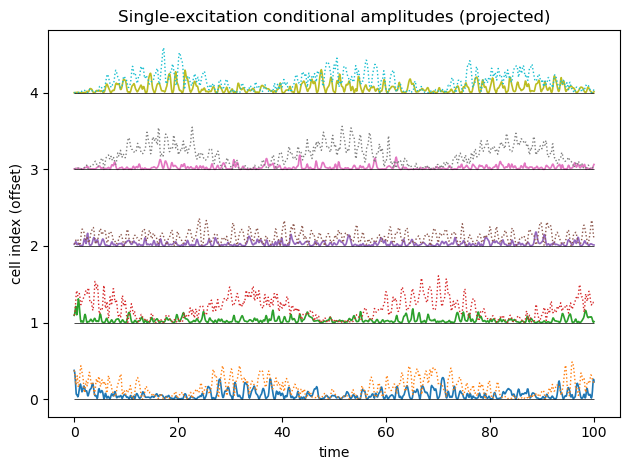

In [110]:
# assumes you already have: states (T x D), L, Nmax, t

# build 1-excitation basis and project
Phi, labels = single_excitation_basis(L, Nmax)   # from earlier reply
C = states @ Phi                                  # shape (T, 2L)

# split into a/b components
T = C.shape[0]
p_a1 = np.zeros((T, L))
p_b1 = np.zeros((T, L))
for k, (which, n) in enumerate(labels):
    if which == 'a':
        p_a1[:, n] = np.abs(C[:, k])**2
    else:  # 'b'
        p_b1[:, n] = np.abs(C[:, k])**2

# total weight in the single-excitation manifold
p1 = (p_a1.sum(axis=1) + p_b1.sum(axis=1))

# conditional probabilities (highlight transfer, factor out leakage)
eps = 1e-10
mask = p1 > 1e-6                      # avoid noisy division when almost no weight remains
pa_cond = np.full_like(p_a1, np.nan)  # NaN gaps when p1 is tiny
pb_cond = np.full_like(p_b1, np.nan)
pa_cond[mask] = (p_a1[mask].T / p1[mask]).T
pb_cond[mask] = (p_b1[mask].T / p1[mask]).T

# plot like your original: solid for a_n, dotted for b_n with vertical offsets
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(L):
    ax.plot(t, pa_cond[:, i] + i, lw=1.2)
    ax.plot(t, pb_cond[:, i] + i, ':', lw=1.0)
    ax.hlines(i, t[0], t[-1], linewidth=0.5, color='k')
ax.set_xlabel('time')
ax.set_ylabel('cell index (offset)')
ax.set_title('Single-excitation conditional amplitudes (projected)')
fig.tight_layout()


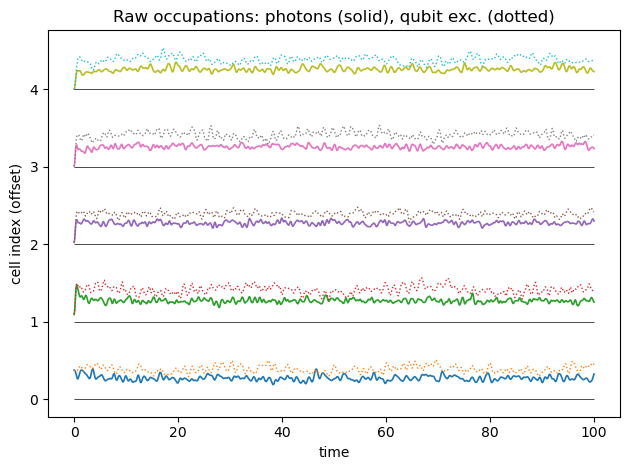

In [111]:
# from earlier: nb(t,i) = <a_i† a_i>, sz(t,i) = <σ^z_i>
p_e = 0.5 * (1.0 + sz)   # excitation probability of qubit i

fig, ax = plt.subplots()
for i in range(L):
    ax.plot(t, nb[:, i] + i, lw=1.2)
    ax.plot(t, p_e[:, i] + i, ':', lw=1.0)
    ax.hlines(i, t[0], t[-1], linewidth=0.5, color='k')
ax.set_xlabel('time')
ax.set_ylabel('cell index (offset)')
ax.set_title('Raw occupations: photons (solid), qubit exc. (dotted)')
fig.tight_layout()
